In [1]:
#Importamos todas las librerias necesarias
import torch
import torchvision
import os
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy 

from torch.utils.data import Dataset
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.utils import save_image
from torchvision.transforms import ToTensor

### Punto A
Se debe implementar una red feed-forward auto-encoder con una capa oculta $n=64$ para aprender la función identidad con la base de datos Fashion-MNIST. 

In [2]:
# Descargamos los conjuntos de datos de entrenamiento y testeo desde la libreria Datasets de torch
train_data = datasets.FashionMNIST(
    root = "data",
    train= True, 
    download= True, 
    transform = ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform= ToTensor(),
)

In [3]:
# Se toma la subclase creada en los prácticos para poder redimensionar las imagénes y los labels
class CustomImageDataset(Dataset):
    def __init__(self,dataset):
        self.dataset=dataset
    def __len__(self):
        return len(self.dataset)   
    def __getitem__(self,i):
        image,label=self.dataset[i]
        label=torch.flatten(image) # Se reescribe el label original con una version achatada de la imagen dado
        # que en este trabajo no estamos clasificando las imagenes, simplemente las estamos reconstruyendo.
        return image,label

In [4]:
train_dataset = CustomImageDataset(train_data)
test_dataset = CustomImageDataset(test_data)

In [5]:
## Hiperparámtros
batch_size = 1000
epochs = 200

In [6]:
# Luego de descargar los datos ahora es necesario cargarlos especificando el tamaño del batch y con el 
# parámetro shuffle estamos permitiendo que las muestras sean aleatorias. 
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

In [7]:
# Dimensiones de los tensores de las imágenes y las etiquetas en el conjunto de entrenamiento
train_imag, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_imag.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([1000, 1, 28, 28])
Labels batch shape: torch.Size([1000, 784])


In [8]:
# Dimensiones de los tensores de las imágenes y las etiquetas en el conjunto de testeo
test_imag, test_labels = next(iter(test_loader))
print(f"Feature batch shape: {test_imag.size()}")
print(f"Labels batch shape: {test_labels.size()}")

Feature batch shape: torch.Size([1000, 1, 28, 28])
Labels batch shape: torch.Size([1000, 784])


In [9]:
# Esta función se utiliza para obtener el dispositivo disponible en mi computadora y para luego "guardar" el modelo ahi
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

In [10]:
# Se define la arquitectura de la red neuronal
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.flatten = nn.Flatten()
        self.drop = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        #encoder
        self.enc1 = nn.Linear(in_features=28*28, out_features= n)

        #decoder
        self.dec1 = nn.Linear(in_features=n, out_features= 28*28)
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.enc1(x)
        x = self.drop(x)
        x = self.relu(x)
        x = self.dec1(x)
        return x

In [11]:
n = 64 #Tamaño capa intermedia
device = get_device()
AE_model = AE().to(device)
print(AE_model)

AE(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (drop): Dropout(p=0.1, inplace=False)
  (relu): ReLU()
  (enc1): Linear(in_features=784, out_features=64, bias=True)
  (dec1): Linear(in_features=64, out_features=784, bias=True)
)


In [12]:
lr = 1 #tasa de aprendizaje
loss_fn = nn.MSELoss() #función de pérdida
optimizer = optim.SGD(AE_model.parameters(), lr = lr) #algoritmo optimizador

In [1]:
#se define la función entrenamiento y de testeo 
train_loss = []
test_loss = []
def train(dataset):
  running_loss = 0
  AE_model.train() #modo entrenamiento
  for batch, (X,y) in enumerate(dataset): #se itera por batch
    optimizer.zero_grad()

    pred = AE_model(X)
    
    loss = loss_fn(pred,y)
    
    loss.backward()
    
    optimizer.step()
    
    running_loss += loss.item()
  #Resultados de la función de pérdida, cada resultado se guarda en el vector vacío train_loss    
  running_loss /= len(train_loader)
  print("Train Loss: {}".format(running_loss))
  train_loss.append(running_loss)

def test(dataset):
  running_test_loss = 0
  AE_model.eval() #modo evaluación (o testeo)
  with torch.no_grad():
    for X, y in dataset:
      pred = AE_model(X)

      loss = loss_fn(pred, y)

      running_test_loss += loss.item()
  #Resultados de la función de pérdida, cada resultado se guarda en el vector vacío test_loss  
  running_test_loss /= len(dataset)
  print("Test Loss: {}".format(running_test_loss))
  test_loss.append(running_test_loss)

In [14]:
# Se entrena el modelo por 200 épocas
for epoch in range(epochs):
  print("Época {} de {}".format(epoch+1, epochs))
  train(train_loader)
  test(test_loader)

Época 1 de 200
Train Loss: 0.13852619975805283
Test Loss: 0.07070421874523163
Época 2 de 200
Train Loss: 0.07405303133030733
Test Loss: 0.06361383609473706
Época 3 de 200
Train Loss: 0.07752436225612959
Test Loss: 0.0614082183688879
Época 4 de 200
Train Loss: 0.07203962579369545
Test Loss: 0.05898295156657696
Época 5 de 200
Train Loss: 0.06720566923419634
Test Loss: 0.057595019787549974
Época 6 de 200
Train Loss: 0.0629918435588479
Test Loss: 0.05981087684631348
Época 7 de 200
Train Loss: 0.060767353201905884
Test Loss: 0.05352604389190674
Época 8 de 200
Train Loss: 0.05758735127747059
Test Loss: 0.05079190097749233
Época 9 de 200
Train Loss: 0.056900291703641415
Test Loss: 0.047940277680754664
Época 10 de 200
Train Loss: 0.05522349290549755
Test Loss: 0.04712793938815594
Época 11 de 200
Train Loss: 0.05278645909080903
Test Loss: 0.04861143529415131
Época 12 de 200
Train Loss: 0.05119304557641347
Test Loss: 0.045057712122797966
Época 13 de 200
Train Loss: 0.0509608568623662
Test Loss: 

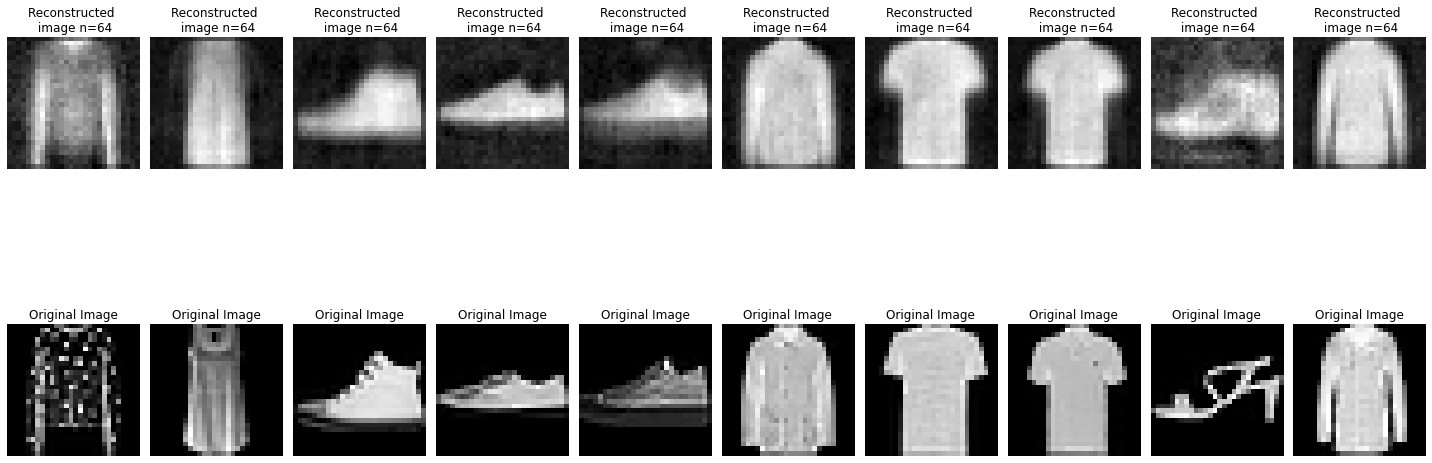

In [15]:
outputs = {}
  
# Se extrae el último batch del dataset de testeo 
img, _ = list(test_loader)[-1]

out = AE_model(img) # Se obtiene el output del modelo para este batch, es decir que vamos a ver como 
# el modelo reconstruye las imágenes 
  
# guardamos en un diccionario la imagen original y la predicha por el modelo
outputs['img'] = img
outputs['out'] = out
  
#Graficamos las imágenes 
counter = 1
val = outputs['out'].detach().numpy()

figure = plt.figure(figsize = (20, 10))  
# predicción de las 10 primeras imagenes del batch 
for idx in range(10):
    plt.subplot(2, 10, counter)
    plt.title("Reconstructed \n image n=64")
    plt.imshow(val[idx].reshape(28, 28), cmap='gray')
    plt.axis('off')
    counter += 1
  
  
# 10 primeras imágenes originales del batch
for idx in range(10):
    val = outputs['img']
    plt.subplot(2, 10, counter)
    plt.imshow(val[idx].reshape(28, 28), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
    counter += 1
  
plt.tight_layout()
plt.savefig('Img64.pdf')
plt.show()

### Punto B
Se realiza nuevamente el punto A para un tamaño de capa oculta igual a 128, 256 y 512. 

In [16]:
n = 128
AE1_model = AE().to(device)
print(AE1_model)

AE(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (drop): Dropout(p=0.1, inplace=False)
  (relu): ReLU()
  (enc1): Linear(in_features=784, out_features=128, bias=True)
  (dec1): Linear(in_features=128, out_features=784, bias=True)
)


In [17]:
lr = 1
optimizer = optim.SGD(AE1_model.parameters(), lr = lr)

In [18]:
train_loss_1 = []
test_loss_1 = []
def train(dataset):
  running_loss = 0
  AE1_model.train()
  for batch, (X,y) in enumerate(dataset):
    optimizer.zero_grad()

    pred = AE1_model(X)
    
    loss = loss_fn(pred,y)
    
    loss.backward()
    
    optimizer.step()
    
    running_loss += loss.item()
        
  running_loss /= len(train_loader)
  print("Train Loss: {}".format(running_loss))
  train_loss_1.append(running_loss)

def test(dataset):
  running_test_loss = 0
  AE1_model.eval()
  with torch.no_grad():
    for X, y in dataset:
      pred = AE1_model(X)

      loss = loss_fn(pred, y)

      running_test_loss += loss.item()
    
  running_test_loss /= len(dataset)
  print("Test Loss: {}".format(running_test_loss))
  test_loss_1.append(running_test_loss)

In [19]:
for epoch in range(epochs):
  print("Época {} de {}".format(epoch+1, epochs))
  train(train_loader)
  test(test_loader)

Época 1 de 200
Train Loss: 0.10573118949929873
Test Loss: 0.061852050572633745
Época 2 de 200
Train Loss: 0.06595060670127471
Test Loss: 0.05496901944279671
Época 3 de 200
Train Loss: 0.05837966638306777
Test Loss: 0.04894607029855251
Época 4 de 200
Train Loss: 0.053198146261274816
Test Loss: 0.045358975604176524
Época 5 de 200
Train Loss: 0.04989866968244314
Test Loss: 0.04264420196413994
Época 6 de 200
Train Loss: 0.047559042399128275
Test Loss: 0.04061529040336609
Época 7 de 200
Train Loss: 0.04698691206673781
Test Loss: 0.047084976360201834
Época 8 de 200
Train Loss: 0.046268419610957304
Test Loss: 0.03863193765282631
Época 9 de 200
Train Loss: 0.04344995797922214
Test Loss: 0.04052012078464031
Época 10 de 200
Train Loss: 0.043119927309453486
Test Loss: 0.03629403486847878
Época 11 de 200
Train Loss: 0.040837474477787815
Test Loss: 0.035023991763591764
Época 12 de 200
Train Loss: 0.04061614399154981
Test Loss: 0.03411133922636509
Época 13 de 200
Train Loss: 0.03944330606609583
Test

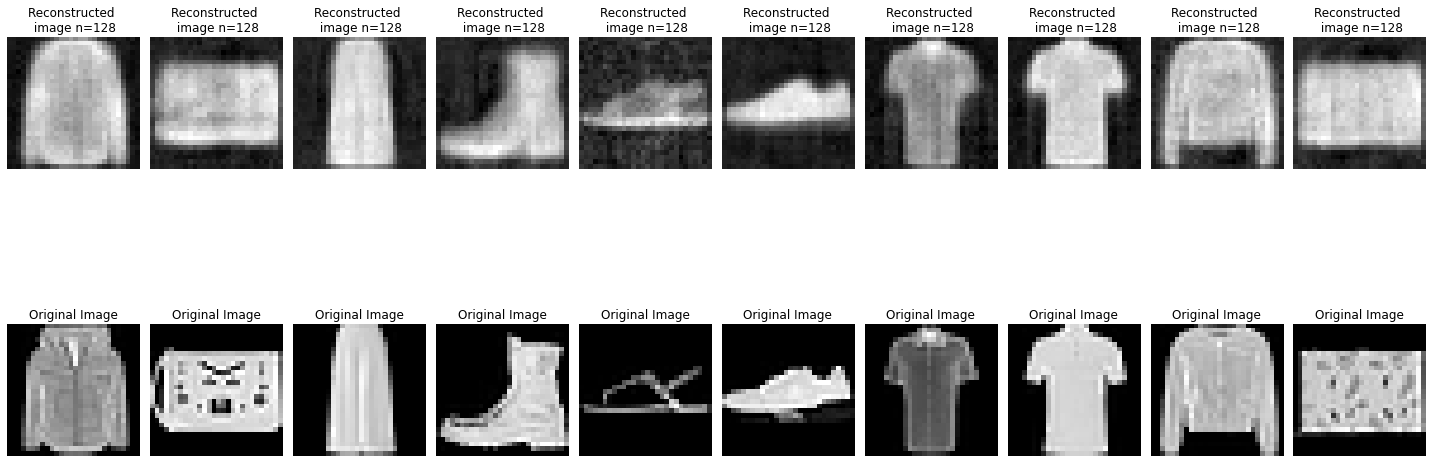

In [20]:
outputs = {}
  
img, _ = list(test_loader)[-1]
  
out = AE1_model(img)
  
outputs['img'] = img
outputs['out'] = out
  
counter = 1
val = outputs['out'].detach().numpy()

figure = plt.figure(figsize = (20, 10))  

for idx in range(10):
    plt.subplot(2, 10, counter)
    plt.title("Reconstructed \n image n=128")
    plt.imshow(val[idx].reshape(28, 28), cmap='gray')
    plt.axis('off')
  

    counter += 1
  

for idx in range(10):
    val = outputs['img']
    plt.subplot(2, 10, counter)
    plt.imshow(val[idx].reshape(28, 28), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    counter += 1
  
plt.tight_layout()
plt.savefig('Img128.pdf')
plt.show()

In [21]:
n = 256
lr = 1
AE2_model = AE().to(device)
print(AE2_model)

AE(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (drop): Dropout(p=0.1, inplace=False)
  (relu): ReLU()
  (enc1): Linear(in_features=784, out_features=256, bias=True)
  (dec1): Linear(in_features=256, out_features=784, bias=True)
)


In [22]:
optimizer = optim.SGD(AE2_model.parameters(), lr = lr)

In [23]:
train_loss_2 = []
test_loss_2 = []
def train(dataset):
  running_loss = 0
  AE2_model.train()
  for batch, (X,y) in enumerate(dataset):
    optimizer.zero_grad()

    pred = AE2_model(X)
    
    loss = loss_fn(pred,y)
    
    loss.backward()
    
    optimizer.step()
    
    running_loss += loss.item()
        
  running_loss /= len(train_loader)
  print("Train Loss: {}".format(running_loss))
  train_loss_2.append(running_loss)

def test(dataset):
  running_test_loss = 0
  AE2_model.eval()
  with torch.no_grad():
    for X, y in dataset:
      pred = AE2_model(X)

      loss = loss_fn(pred, y)

      running_test_loss += loss.item()
    
  running_test_loss /= len(dataset)
  print("Test Loss: {}".format(running_test_loss))
  test_loss_2.append(running_test_loss)

In [24]:
for epoch in range(epochs):
  print("Época {} de {}".format(epoch+1, epochs))
  train(train_loader)
  test(test_loader)

Época 1 de 200
Train Loss: 0.08891567202905813
Test Loss: 0.05601681731641293
Época 2 de 200
Train Loss: 0.056408811795214814
Test Loss: 0.04564997479319573
Época 3 de 200
Train Loss: 0.04857830591499805
Test Loss: 0.04092349670827389
Época 4 de 200
Train Loss: 0.044457889162003994
Test Loss: 0.037915035337209704
Época 5 de 200
Train Loss: 0.04160095248371363
Test Loss: 0.03563954457640648
Época 6 de 200
Train Loss: 0.039329175278544425
Test Loss: 0.033720124140381814
Época 7 de 200
Train Loss: 0.03745271861553192
Test Loss: 0.03214350342750549
Época 8 de 200
Train Loss: 0.03590277961144845
Test Loss: 0.030873082205653192
Época 9 de 200
Train Loss: 0.03457936178892851
Test Loss: 0.02975453082472086
Época 10 de 200
Train Loss: 0.03350393952180942
Test Loss: 0.028810898214578627
Época 11 de 200
Train Loss: 0.03254586265732844
Test Loss: 0.028001427464187146
Época 12 de 200
Train Loss: 0.03172507438187798
Test Loss: 0.02736127432435751
Época 13 de 200
Train Loss: 0.031049239387114843
Test

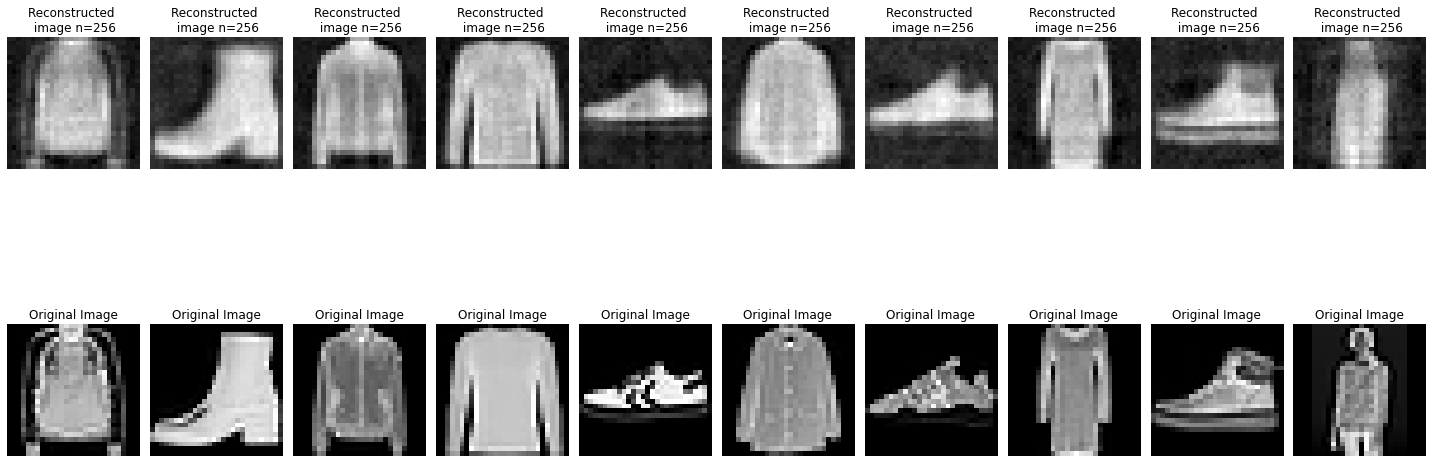

In [32]:
outputs = {}
  
img, _ = list(test_loader)[-1]

out = AE2_model(img)
  
outputs['img'] = img
outputs['out'] = out
  

counter = 1
val = outputs['out'].detach().numpy()

figure = plt.figure(figsize = (20, 10))  

for idx in range(10):
    plt.subplot(2, 10, counter)
    plt.title("Reconstructed \n image n=256")
    plt.imshow(val[idx].reshape(28, 28), cmap='gray')
    plt.axis('off')
  
    counter += 1
  
# Plotting original images
  
for idx in range(10):
    val = outputs['img']
    plt.subplot(2, 10, counter)
    plt.imshow(val[idx].reshape(28, 28), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
  
    counter += 1
  
plt.tight_layout()
plt.savefig('Img256.pdf')
plt.show()

In [26]:
n = 512 
lr = 1
AE3_model = AE().to(device)
print(AE3_model)

AE(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (drop): Dropout(p=0.1, inplace=False)
  (relu): ReLU()
  (enc1): Linear(in_features=784, out_features=512, bias=True)
  (dec1): Linear(in_features=512, out_features=784, bias=True)
)


In [27]:
optimizer = optim.SGD(AE3_model.parameters(), lr = lr)

In [28]:
train_loss_3 = []
test_loss_3 = []
def train(dataset):
  running_loss = 0
  AE3_model.train()
  for batch, (X,y) in enumerate(dataset):
    optimizer.zero_grad()

    pred = AE3_model(X)
    
    loss = loss_fn(pred,y)
    
    loss.backward()
    
    optimizer.step()
    
    running_loss += loss.item()
        
  running_loss /= len(train_loader)
  print("Train Loss: {}".format(running_loss))
  train_loss_3.append(running_loss)

def test(dataset):
  running_test_loss = 0
  AE3_model.eval()
  with torch.no_grad():
    for X, y in dataset:
      pred = AE3_model(X)

      loss = loss_fn(pred, y)

      running_test_loss += loss.item()
    
  running_test_loss /= len(dataset)
  print("Test Loss: {}".format(running_test_loss))
  test_loss_3.append(running_test_loss)

In [29]:
for epoch in range(epochs):
  print("Época {} de {}".format(epoch+1, epochs))
  train(train_loader)
  test(test_loader)

Época 1 de 200
Train Loss: 0.07899996414780616
Test Loss: 0.050446794182062146
Época 2 de 200
Train Loss: 0.049642244912683965
Test Loss: 0.041089342534542085
Época 3 de 200
Train Loss: 0.04293532601247231
Test Loss: 0.036610692366957666
Época 4 de 200
Train Loss: 0.038938408407072224
Test Loss: 0.03351020030677319
Época 5 de 200
Train Loss: 0.03607014200339715
Test Loss: 0.031228218413889407
Época 6 de 200
Train Loss: 0.03393875882029533
Test Loss: 0.029512650147080422
Época 7 de 200
Train Loss: 0.032333758845925334
Test Loss: 0.02820535786449909
Época 8 de 200
Train Loss: 0.031074916509290538
Test Loss: 0.027202200889587403
Época 9 de 200
Train Loss: 0.030076661923279364
Test Loss: 0.026354392617940904
Época 10 de 200
Train Loss: 0.029227625081936517
Test Loss: 0.025658464059233665
Época 11 de 200
Train Loss: 0.028499208794285854
Test Loss: 0.025039762258529663
Época 12 de 200
Train Loss: 0.02784081045538187
Test Loss: 0.02448804918676615
Época 13 de 200
Train Loss: 0.027283362733821

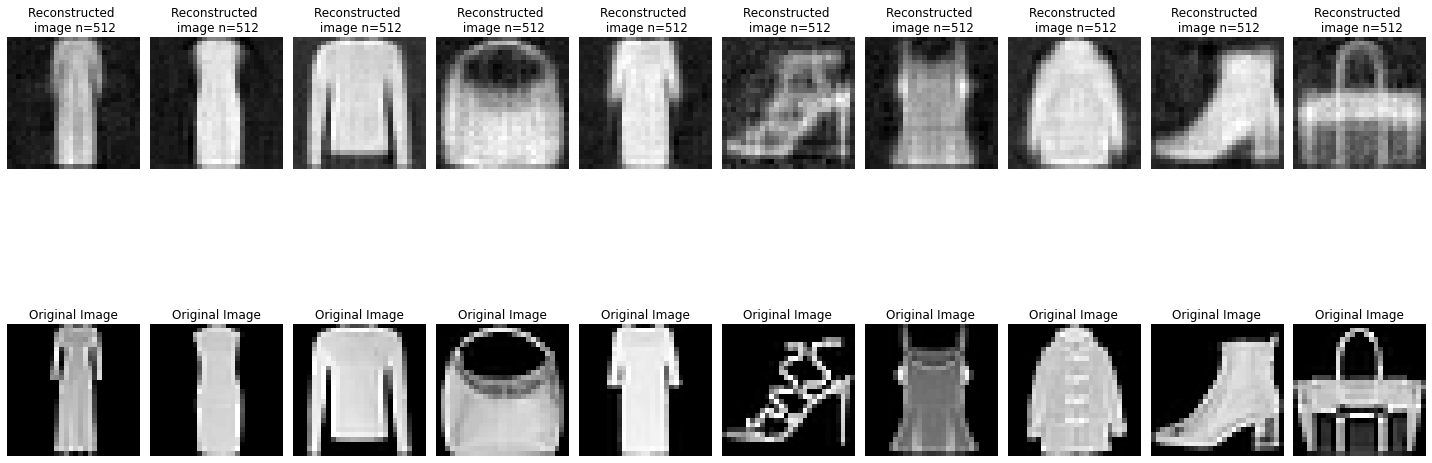

In [67]:
outputs = {}
  
img, _ = list(test_loader)[-1]

out = AE3_model(img)
  
outputs['img'] = img
outputs['out'] = out
  

counter = 1
val = outputs['out'].detach().numpy()

figure = plt.figure(figsize = (20, 10))  

for idx in range(10):
    plt.subplot(2, 10, counter)
    plt.title("Reconstructed \n image n=512")
    plt.imshow(val[idx].reshape(28, 28), cmap='gray')
    plt.axis('off')

    counter += 1
  

for idx in range(10):
    val = outputs['img']
    plt.subplot(2, 10, counter)
    plt.imshow(val[idx].reshape(28, 28), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
  
    counter += 1
  
plt.tight_layout()
plt.savefig('Img512.pdf')
plt.show()

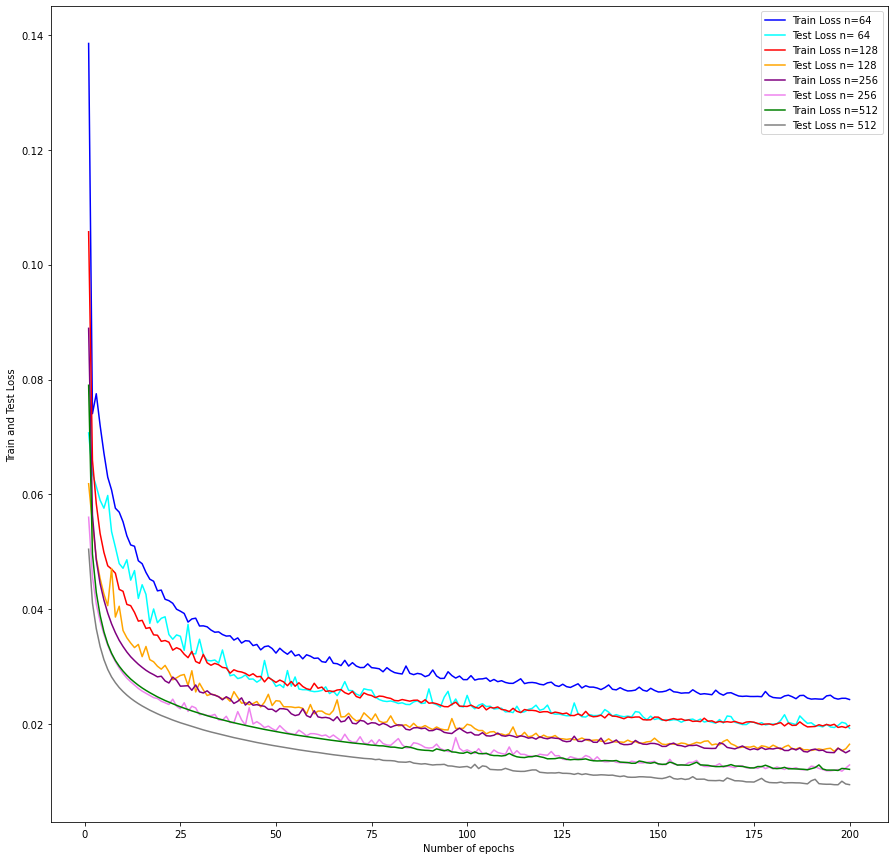

In [31]:
# Se grafican tanto las funciones de pérdida de entrenamiento y de testeo para cada tamaño de capa intermedia
figure = plt.figure(figsize = (15,15))
plt.plot(range(1,epochs+1),train_loss, color='blue', label ='Train Loss n=64')
plt.plot(range(1,epochs+1),test_loss, color='cyan', label ='Test Loss n= 64')
plt.plot(range(1,epochs+1),train_loss_1, color='red', label ='Train Loss n=128')
plt.plot(range(1,epochs+1),test_loss_1, color='orange', label ='Test Loss n= 128')
plt.plot(range(1,epochs+1),train_loss_2, color='purple', label ='Train Loss n=256')
plt.plot(range(1,epochs+1),test_loss_2, color='violet', label ='Test Loss n= 256')
plt.plot(range(1,epochs+1),train_loss_3, color='green', label ='Train Loss n=512')
plt.plot(range(1,epochs+1),test_loss_3, color='grey', label ='Test Loss n= 512')
plt.xlabel("Number of epochs")
plt.ylabel("Train and Test Loss")
plt.legend(loc = 'upper right')
plt.savefig('Loss.pdf')
plt.show()

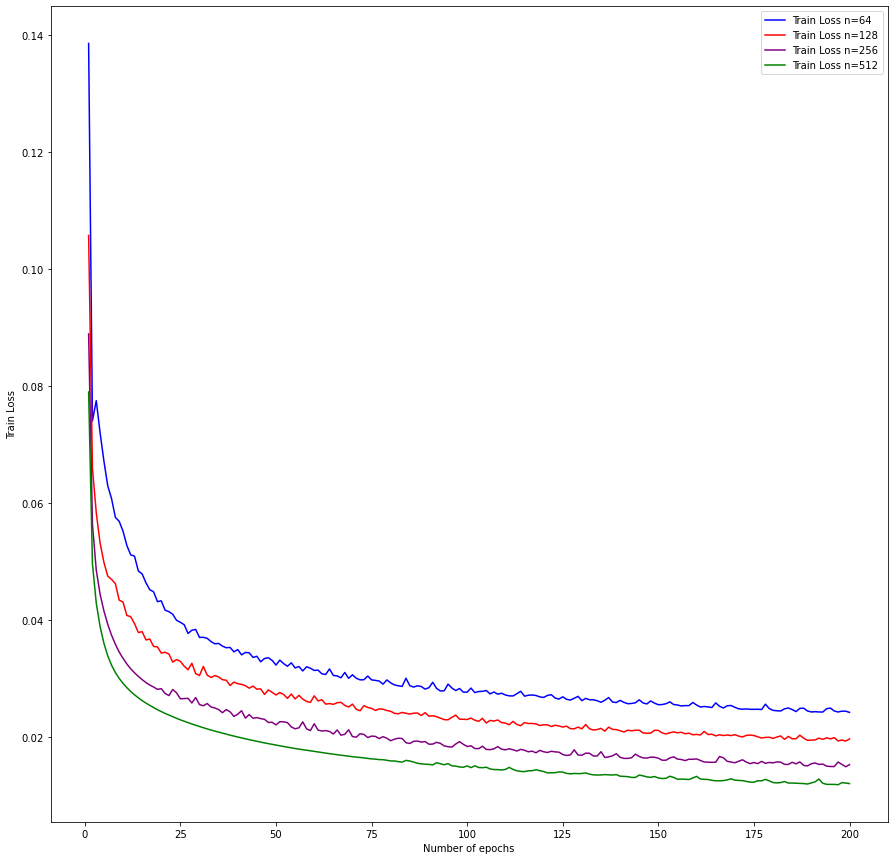

In [68]:
# Graficos de las funciones de entrenamiento para cada tamaño de capa intermedia
figure = plt.figure(figsize = (15,15))
plt.plot(range(1,epochs+1),train_loss, color='blue', label ='Train Loss n=64')
plt.plot(range(1,epochs+1),train_loss_1, color='red', label ='Train Loss n=128')
plt.plot(range(1,epochs+1),train_loss_2, color='purple', label ='Train Loss n=256')
plt.plot(range(1,epochs+1),train_loss_3, color='green', label ='Train Loss n=512')
plt.xlabel("Number of epochs")
plt.ylabel("Train Loss")
plt.legend(loc = 'upper right')
plt.savefig('Train Loss.pdf')
plt.show()

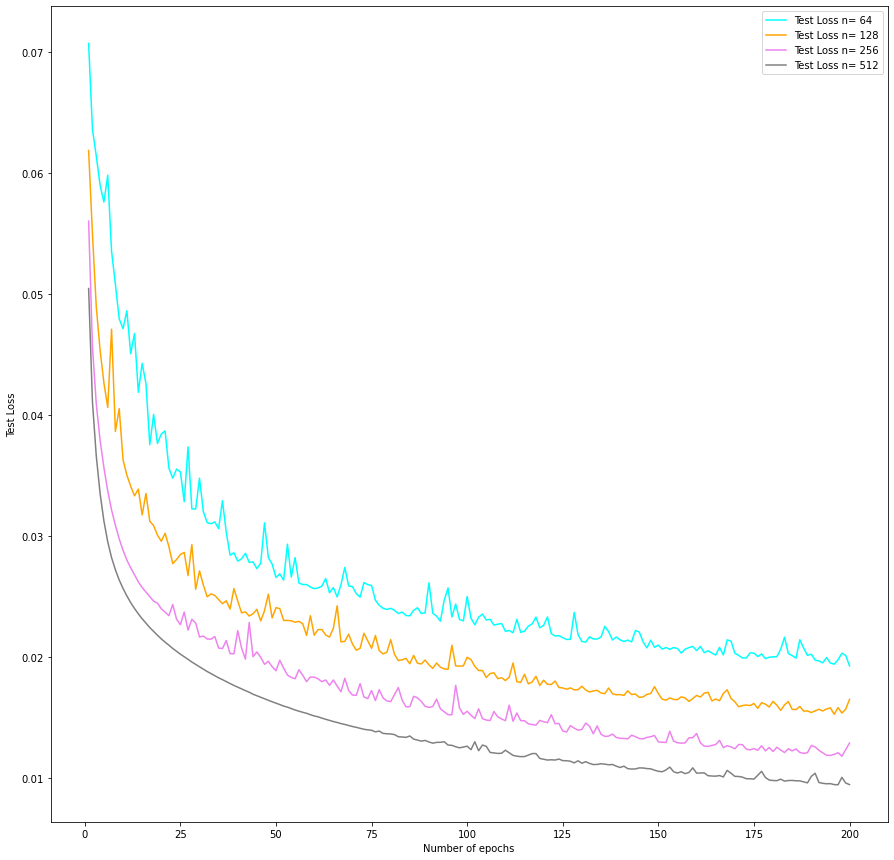

In [69]:
# Gráficos de las funciones de testeo para cada capa intermedia
figure = plt.figure(figsize = (15,15))
plt.plot(range(1,epochs+1),test_loss, color='cyan', label ='Test Loss n= 64')
plt.plot(range(1,epochs+1),test_loss_1, color='orange', label ='Test Loss n= 128')
plt.plot(range(1,epochs+1),test_loss_2, color='violet', label ='Test Loss n= 256')
plt.plot(range(1,epochs+1),test_loss_3, color='grey', label ='Test Loss n= 512')
plt.xlabel("Number of epochs")
plt.ylabel("Test Loss")
plt.legend(loc = 'upper right')
plt.savefig('Test Loss.pdf')
plt.show()